In [18]:
#%% Package imports

# Install the Python control library
# %pip install -q control

# Numerical and CVXPY packages
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import andes
from sippy_unipi import system_identification as sysid
import casadi as ca 
from control import ss


# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
# %config InlineBackend.figure_format = 'svg'
plt.style.use('tableau-colorblind10')

# Configuration
np.random.seed(0)  # For reproducibility

In [19]:
## Config

dt = 0.05									# Sampling time in seconds
tf_data_collection = 5						# Final time in seconds
t_data_collection = np.arange(
    0, tf_data_collection, dt)				# Time vector
L = 10										# Hankel window length
N = 6										# Prediction horizon


## 1) Collect IO dataset

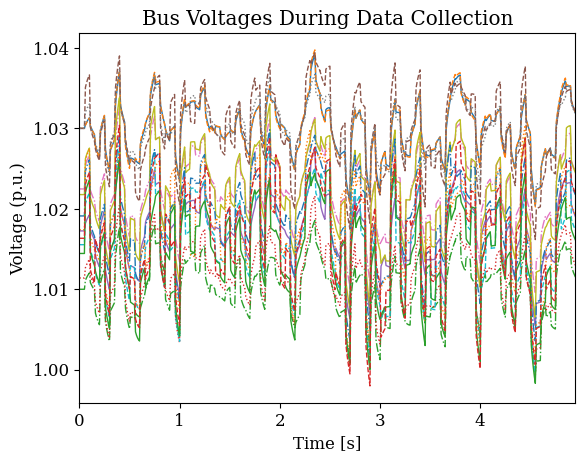

In [ ]:
from tqdm import tqdm
tqdm.disable = True

andes.config_logger(stream_level=50)
ss = andes.run('ieee14.xlsx', default_config=True)
ss.TDS.config.diagnose = 1
ss.TDS.config.verbose = 2
ss.TDS.config.tf = tf_data_collection
ss.TDS.config.criteria = 0
ss.TDS.config.tstep = 0.01

# Configure PQ loads so they are controllable. Setting these params is required to change loads during simulation
ss.PQ.config.p2p = 1.0
ss.PQ.config.p2i = 0
ss.PQ.config.p2z = 0

ss.PQ.config.q2q = 1.0
ss.PQ.config.q2i = 0
ss.PQ.config.q2z = 0

p = ss.Bus.Vn.n    						# Number of outputs (one per bus)
num_controllable_loads = ss.PQ.Vn.n		# Number of controllable loads
m = num_controllable_loads * 2			# Number of inputs (P and Q per controllable load)
controllable_loads = ss.PQ.idx.v

# Generate random input perturbations
u_pe = np.random.standard_normal((len(t_data_collection), m)) * 0.01

# Add base values to inputs
PQ_base = np.empty(m)
PQ_base[0::2] = ss.PQ.Ppf.v.copy()
PQ_base[1::2] = ss.PQ.Qpf.v.copy()

u_pe += PQ_base

for i, t in enumerate(t_data_collection[:-1]):
	# Apply inputs
	for j, load_idx in enumerate(controllable_loads):
		ss.PQ.Ppf.v[j] = u_pe[i, j*2]
		ss.PQ.Qpf.v[j] = u_pe[i, j*2+1]
		# ss.PQ.alter(src='p0', idx=load_idx, value=u_pe[i, j*2], attr='v')
		# ss.PQ.alter(src='q0', idx=load_idx, value=u_pe[i, j*2+1], attr='v')
	
	print("Power Setpoints: ", ss.PQ.Ppf.v)

	ss.TDS.config.tf = t_data_collection[i+1]
	ss.TDS.run()

	

from IPython.display import clear_output
clear_output()

if ss.TDS.load_plotter() is None:
	ss.TDS.load_plotter()

fig, ax = ss.TDS.plt.plot(
	(81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94),
	plot_type='line',
	title='Bus Voltages During Data Collection',
	ylabel='Voltage (p.u.)')
plt.show()


In [46]:
print(ss.PQ.doc())

Model <PQ> in Group <StaticLoad>
PQ load model.

Implements an automatic pq2z conversion during power flow when the voltage
is outside [vmin, vmax]. The conversion can be turned off by setting `pq2z`
to 0 in the Config file.

Before time-domain simulation, PQ load will be converted to impedance,
current source, and power source based on the weights in the Config file.

Weights (p2p, p2i, p2z) corresponds to the weights for constant power,
constant current and constant impedance. p2p, p2i and p2z must be in decimal
numbers and sum up exactly to 1. The same rule applies to (q2q, q2i, q2z).

To alter the PQ load in terms of power during simulation, one needs to set
the conversion weights to preserve the constant power portion. For example,
the PQ can remain as constant power load by setting

.. code-block :: python

    ss.PQ.config.p2p = 1.0
    ss.PQ.config.p2i = 0
    ss.PQ.config.p2z = 0

    ss.PQ.config.q2q = 1.0
    ss.PQ.config.q2i = 0
    ss.PQ.config.q2z = 0

Then, the constant 